<a href="https://colab.research.google.com/github/soumya0422/FitPulse-Health-Anomaly-Detection-from-Fitness-Devices-/blob/main/anomaly_detection_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from prophet import Prophet

# Load processed features and original dataset
# The path below is to a directory, not a CSV file, which caused the IsADirectoryError.
# Please provide the full path to the actual CSV file you want to load from this directory.
# features = pd.read_csv("/content/drive/MyDrive/FitPulse Health Anomaly Detection")
features = pd.read_csv("/content/drive/MyDrive/FitPulse Health Anomaly Detection/Milestone2/data/extracted_features.csv") # Placeholder: Replace 'features_data.csv' with your actual CSV file name
df = pd.read_csv("/content/drive/MyDrive/processed_data.csv", parse_dates=["Time"])

print("Features shape:", features.shape)
print("Original dataset shape:", df.shape)


Features shape: (14, 1978)
Original dataset shape: (6034, 8)


In [ ]:
# Scale features for clustering
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X_scaled)
features["kmeans_cluster"] = clusters

# Silhouette Score
sil_score = silhouette_score(X_scaled, clusters)
print("KMeans Silhouette Score:", sil_score)

# Distance from cluster center (for anomaly scoring)
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[clusters], axis=1)
features["distance_from_center"] = distances


KMeans Silhouette Score: 0.13504137718332757


In [ ]:
# Aggregate heart_rate per time for trend modeling
prophet_df = df.groupby("Time", as_index=False).agg(y=("heart_rate", "mean")).rename(columns={"Time": "ds"})

# Remove timezone information from 'ds' column as Prophet does not support it
prophet_df["ds"] = prophet_df["ds"].dt.tz_localize(None)

# Fit Prophet model
model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(prophet_df)

# Predict trend
future = model.make_future_dataframe(periods=0, freq="h")
forecast = model.predict(future)

# Compute residuals
prophet_df = prophet_df.merge(forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]], on="ds")
prophet_df["residual"] = prophet_df["y"] - prophet_df["yhat"]

# Flag anomalies based on confidence intervals
prophet_df["anomaly_prophet"] = ((prophet_df["y"] > prophet_df["yhat_upper"]) | (prophet_df["y"] < prophet_df["yhat_lower"])).astype(int)

print("Detected anomalies from Prophet:", prophet_df["anomaly_prophet"].sum())


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Detected anomalies from Prophet: 136


In [ ]:
# Optional: define anomaly threshold (top 5% farthest points from cluster center)
threshold = np.percentile(features["distance_from_center"], 95)
features["anomaly_cluster"] = (features["distance_from_center"] > threshold).astype(int)

print("Detected anomalies from clustering:", features["anomaly_cluster"].sum())


Detected anomalies from clustering: 1


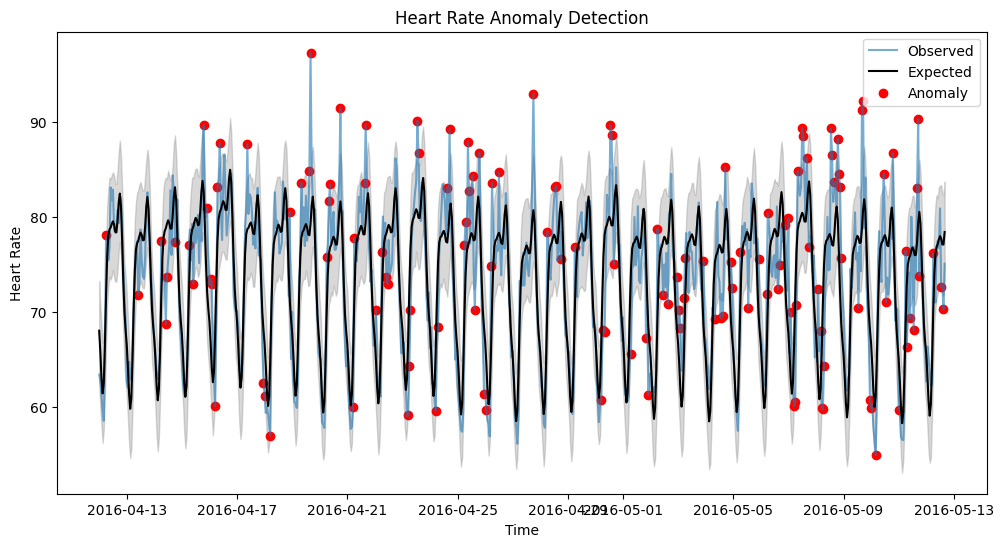

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(prophet_df["ds"], prophet_df["y"], label="Observed", alpha=0.6)
plt.plot(prophet_df["ds"], prophet_df["yhat"], label="Expected", color="black")
plt.fill_between(prophet_df["ds"], prophet_df["yhat_lower"], prophet_df["yhat_upper"], color="gray", alpha=0.3)

# Highlight anomalies
anomalies = prophet_df[prophet_df["anomaly_prophet"] == 1]
plt.scatter(anomalies["ds"], anomalies["y"], color="red", label="Anomaly")

plt.xlabel("Time")
plt.ylabel("Heart Rate")
plt.title("Heart Rate Anomaly Detection")
plt.legend()
plt.show()


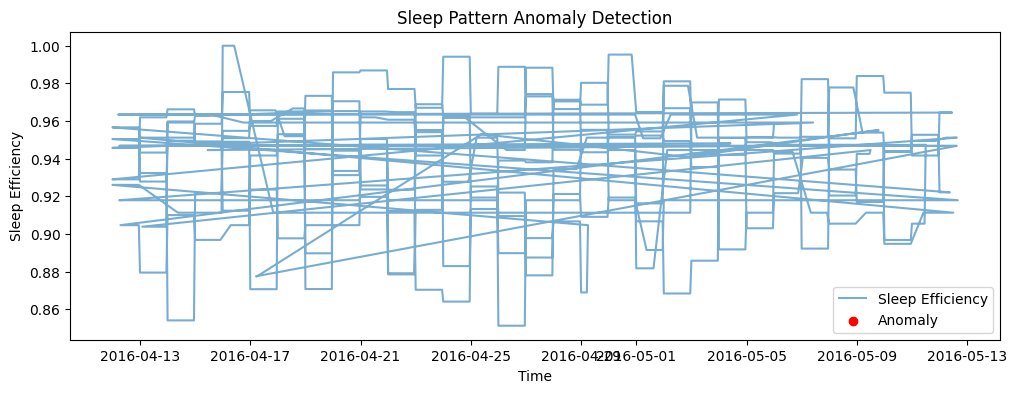

In [ ]:
# Example using sleep efficiency
df["sleep_anomaly"] = (df["sleep_efficiency"] < 0.7).astype(int)  # Threshold can be adjusted

plt.figure(figsize=(12, 4))
plt.plot(df["Time"], df["sleep_efficiency"], label="Sleep Efficiency", alpha=0.6)
plt.scatter(df.loc[df["sleep_anomaly"]==1, "Time"], df.loc[df["sleep_anomaly"]==1, "sleep_efficiency"],
            color="red", label="Anomaly")
plt.xlabel("Time")
plt.ylabel("Sleep Efficiency")
plt.title("Sleep Pattern Anomaly Detection")
plt.legend()
plt.show()


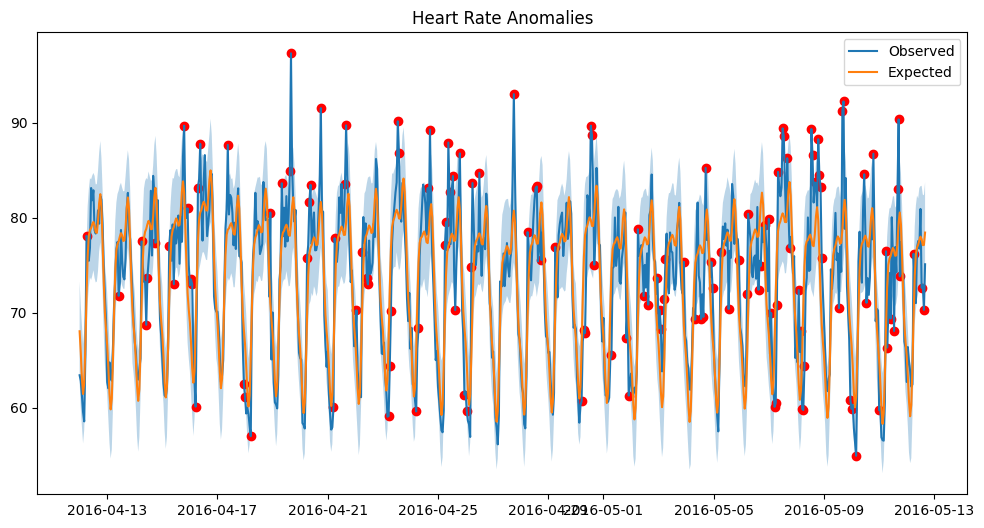

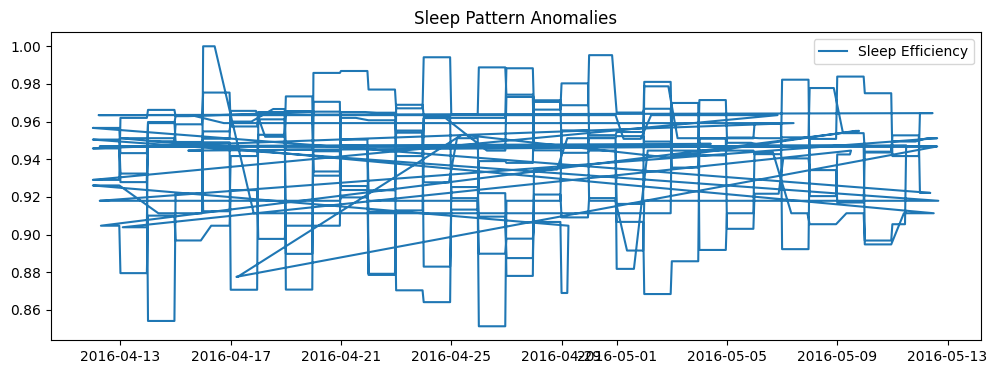

In [ ]:
# Create visualizations folder
import os
os.makedirs("visualizations", exist_ok=True)
os.makedirs("data", exist_ok=True)

# Save figures
plt.figure(figsize=(12, 6))
plt.plot(prophet_df["ds"], prophet_df["y"], label="Observed")
plt.plot(prophet_df["ds"], prophet_df["yhat"], label="Expected")
plt.fill_between(prophet_df["ds"], prophet_df["yhat_lower"], prophet_df["yhat_upper"], alpha=0.3)
plt.scatter(anomalies["ds"], anomalies["y"], color="red")
plt.legend()
plt.title("Heart Rate Anomalies")
plt.savefig("visualizations/heart_rate_anomalies.png")

# Save sleep anomalies
plt.figure(figsize=(12, 4))
plt.plot(df["Time"], df["sleep_efficiency"], label="Sleep Efficiency")
plt.scatter(df.loc[df["sleep_anomaly"]==1, "Time"], df.loc[df["sleep_anomaly"]==1, "sleep_efficiency"], color="red")
plt.legend()
plt.title("Sleep Pattern Anomalies")
plt.savefig("visualizations/sleep_anomalies.png")

# Save labeled datasets
features.to_csv("data/behavioral_features_with_anomalies.csv", index=False)
prophet_df.to_csv("data/heart_rate_trends_with_anomalies.csv", index=False)


In [ ]:

# Heart rate thresholds (domain-driven)
HR_LOW = 50
HR_HIGH = 120

df['hr_threshold_anomaly'] = (
    (df['heart_rate'] < HR_LOW) | (df['heart_rate'] > HR_HIGH)
).astype(int)

# Sleep efficiency thresholds
SLEEP_LOW = 0.9
SLEEP_HIGH = 1.0

df['sleep_threshold_anomaly'] = (
    (df['sleep_efficiency'] < SLEEP_LOW) | (df['sleep_efficiency'] > SLEEP_HIGH)
).astype(int)

print("Threshold-based anomalies computed")


Threshold-based anomalies computed


In [ ]:

df['Time'] = pd.to_datetime(df['Time']).dt.tz_localize(None)

prophet_df = (
    df.groupby("Time", as_index=False)
      .agg(y=("heart_rate", "mean"))
      .rename(columns={"Time": "ds"})
)

model = Prophet(daily_seasonality=True, weekly_seasonality=True)
model.fit(prophet_df)

forecast = model.predict(prophet_df[['ds']])

trend_df = prophet_df.merge(
    forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds'
)

trend_df['prophet_anomaly'] = (
    (trend_df['y'] > trend_df['yhat_upper']) |
    (trend_df['y'] < trend_df['yhat_lower'])
).astype(int)

print("Prophet anomalies detected:", trend_df['prophet_anomaly'].sum())


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Prophet anomalies detected: 144


In [ ]:

# Merge Prophet anomalies back into main dataframe
df = df.merge(
    trend_df[['ds', 'prophet_anomaly']],
    left_on='Time',
    right_on='ds',
    how='left'
)

df['prophet_anomaly'] = df['prophet_anomaly'].fillna(0)

# Rule-based cluster assignment
def assign_rule_cluster(row):
    if row['prophet_anomaly'] == 1:
        return 'Model-Based Anomaly'
    elif row['hr_threshold_anomaly'] == 1 or row['sleep_threshold_anomaly'] == 1:
        return 'Rule-Based Anomaly'
    else:
        return 'Normal Behavior'

df['rule_based_cluster'] = df.apply(assign_rule_cluster, axis=1)

print(df['rule_based_cluster'].value_counts())


rule_based_cluster
Normal Behavior        4375
Model-Based Anomaly    1109
Rule-Based Anomaly      550
Name: count, dtype: int64


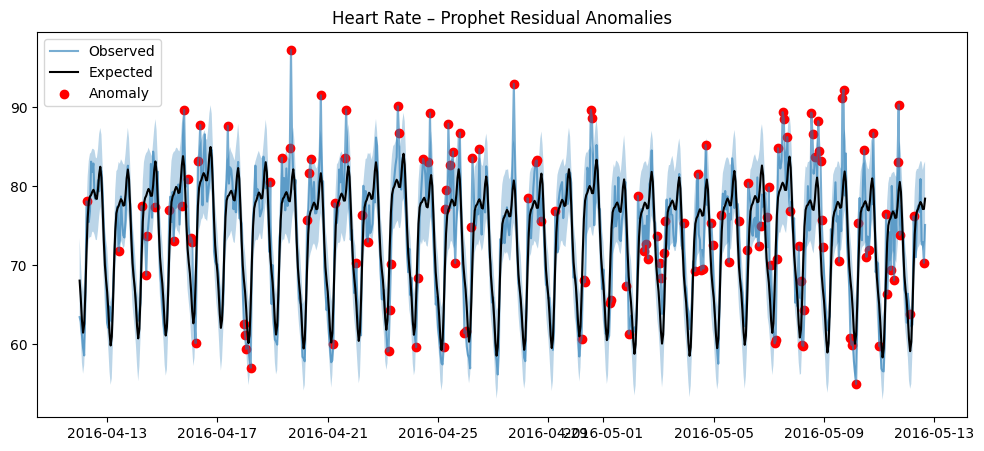

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(trend_df['ds'], trend_df['y'], label='Observed', alpha=0.6)
plt.plot(trend_df['ds'], trend_df['yhat'], label='Expected', color='black')
plt.fill_between(
    trend_df['ds'],
    trend_df['yhat_lower'],
    trend_df['yhat_upper'],
    alpha=0.3
)

plt.scatter(
    trend_df.loc[trend_df['prophet_anomaly'] == 1, 'ds'],
    trend_df.loc[trend_df['prophet_anomaly'] == 1, 'y'],
    color='red',
    label='Anomaly'
)

plt.legend()
plt.title("Heart Rate – Prophet Residual Anomalies")
plt.show()


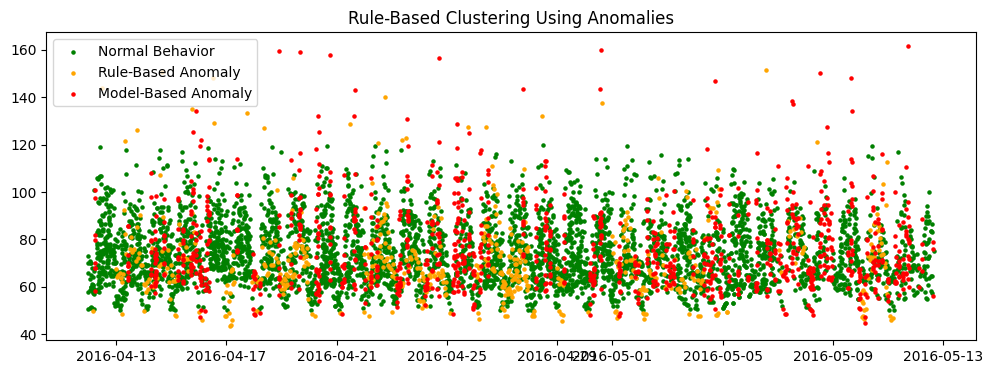

In [ ]:
plt.figure(figsize=(12,4))

colors = {
    'Normal Behavior': 'green',
    'Rule-Based Anomaly': 'orange',
    'Model-Based Anomaly': 'red'
}

for label, color in colors.items():
    subset = df[df['rule_based_cluster'] == label]
    plt.scatter(subset['Time'], subset['heart_rate'], s=5, label=label, color=color)

plt.legend()
plt.title("Rule-Based Clustering Using Anomalies")
plt.show()
